In [ ]:
'''
api_distinct_cnt: file调用了多少不同的API ;
api_cnt: file调用api的总数；
api_cnt_mean: file调用API的平均值；
call_pid_distinct_cnt: file调用了多少不同的进程；
call_pid_cnt_max,tid_api_cnt_min,tid_api_cnt_mean: ","file中的线程调用的 最多/最少/平均 api数目;

value_equals0_cnt: file返回值为0的样本数;
value_equals0_rate： file返回值为0的样本比率;
value_distinct_cnt: file有多少不同的返回值;

'''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter
import pickle
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [108]:
data = pd.read_csv("origin_train_data.csv")

In [129]:
def get_value(x, kind="mean"):
    dict_ = Counter(x.split())
    tmp = sorted(dict_.values())
    if kind == "mean":
        return sum(dict_.values()) / len(dict_)   
    if kind == "max":
        return tmp[-1]
    if kind == "min":
        return tmp[0]

In [133]:
data["api_cnt"] = data["api_name"].apply(lambda x: len(x.split()))
data["api_distinct_cnt"] = data["api_name"].apply(lambda x: len(set(x.split())))
data["api_cnt_mean"] = data["api_name"].apply(lambda x: get_value(x))
data["call_pid_distinct_cnt"] = data["call_pid"].apply(lambda x: len(set(x.split())))
data["call_pid_cnt_mean"] = data["call_pid"].apply(lambda x: get_value(x))
data["call_pid_cnt_max"] = data["call_pid"].apply(lambda x: get_value(x, kind="max"))
data["call_pid_cnt_min"] = data["call_pid"].apply(lambda x: get_value(x, kind="min"))

In [152]:
merge_data.head()

,id,safe_type,NtSetSystemInformation,StartServiceW,HttpOpenRequestA,NtCreateThread,CryptExportKey,NtQueryFullAttributesFile,NtDeleteFile,LoadLibraryExW,...,1528,1088,3176,api_cnt,api_distinct_cnt,api_cnt_mean,call_pid_distinct_cnt,call_pid_cnt_mean,call_pid_cnt_max,call_pid_cnt_min
0,2561f1024e97920a21607ab7ced6ae262e641fe9d93dfd...,0,0,0,0,0,0,0,0,24,...,0,0,0,46,11,4.181818,3,15.333333,39,2
1,fa9e8dcf8766972f79a216c12d43b257f7475da0502880...,0,0,0,0,0,2,2,0,117,...,0,0,0,357,16,22.312500,5,71.400000,151,2
2,1071e1e8aa5ca45aec4f48f582f6d009d3e55aa16fadbb...,0,0,0,0,0,0,2,0,74,...,0,0,0,829,28,29.607143,3,276.333333,652,2
3,7fdbfff08317760811f9b1624d1d9a941a3d5066b7784d...,0,0,0,40,0,0,6,0,76,...,0,0,0,2897,42,68.976190,2,1448.500000,2892,5
4,2e1ce04ba49c2e10fe6a1fca97d64066ed90e7d21ad563...,1,0,0,16,72,0,0,0,90,...,95,0,0,5778,40,144.450000,34,169.941176,3485,10


In [3]:
data = pd.read_csv("train_features.csv")

In [4]:
data.head()

,id,safe_type,api_cnt,api_distinct_cnt,api_cnt_mean,call_pid_distinct_cnt,call_pid_cnt_mean,call_pid_cnt_max,call_pid_cnt_min,ret_value_equals0_cnt,ret_value_equals0_rate,ret_value_distinct_cnt
0,8e4e1572c39cc7f926f9aa84754b9d4d58e0eb3745b08b...,0,67,18,3.722222,2,33.500000,65,2,40,0.597015,8
1,7d0a108bce59f6738cc1e162f7c2c7e551100eeaa25145...,0,88,13,6.769231,2,44.000000,86,2,48,0.545455,9
2,e1ee9a568e7527aa1ed731258666523dfc6f0958730a0d...,0,34,10,3.400000,2,17.000000,32,2,20,0.588235,7
3,15a0d0ed2c1b0b8e1505381d864dac5e3a9bfa666fa8e3...,0,281,23,12.217391,3,93.666667,229,2,64,0.227758,12
4,520545a7437044735919576886ecd366493c15924283a4...,0,839,28,29.964286,3,279.666667,474,2,369,0.439809,65


In [40]:
features = np.delete(stacking_train, 3, axis=1)

In [43]:
train_data, test_data, train_label, test_label = train_test_split(features, 
                                                                  safe_type, 
                                                                  test_size=0.2, 
                                                                  random_state=1)

In [21]:
# with open("stacking_train.pkl", "rb") as fp:
#     stacking_train = pickle.load(fp)
# with open("stacking_test.pkl", "rb") as fp:
#     stacking_test = pickle.load(fp)
# id_ = pd.read_csv("test_features.csv")["id"]
safe_type = pd.read_csv("safe_type.csv", header=None)

In [46]:
model = XGBClassifier(ax_depth=7,
                      learning_rate=0.05,
                      n_estimators=1000,
                      random_state=0) 
model.fit(stacking_train, safe_type.values.flatten())            
y_pred = model.predict(stacking_test)

In [10]:
def plot(test_label, y_pred, model):
    font = {"color": "darkred",
            "size": 13, 
            "family" : "serif"}

    accs = accuracy_score(test_label, y_pred)
    fpr, tpr, _ = metrics.roc_curve(test_label,  y_pred)
    auc = metrics.roc_auc_score(test_label, y_pred)
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="{}, auc=".format(model)+str(auc), color='green', linewidth=2)
    ax.set_title("ROC curve", fontdict=font)
    leg = ax.legend(loc="best")
    text = leg.get_texts()
    _ = plt.setp(text, color="blue") 

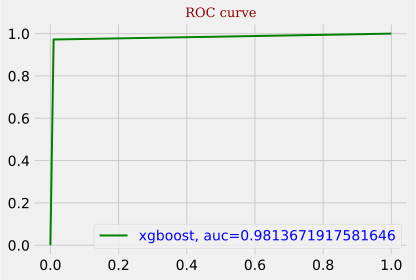

In [35]:
plot(test_label, y_pred, "xgboost")

In [47]:
y_pred.sum(axis=0)

4919

In [48]:
result = pd.DataFrame()
result["id"] = id_
result["safe_type"] = y_pred

In [49]:
result.head()

,id,safe_type
0,87fd6e00a5332d195e6074cbfb86bf38b47d40d443f0ba...,0
1,75a0f52741268faa642d1a396a36ab127d33f8f1dfa437...,0
2,97f1ec2cc7ae14a57a4b9d24953678689421c583f5339a...,0
3,8b944b464c38824434cfe8cafa0a9607ba519bafcd81cf...,1
4,e477ff935c03c476110d646a49e3e9894a879b81b916c5...,0


In [50]:
result.to_csv("result.csv", index=False, encoding="utf-8")

In [51]:
adjust = pd.read_csv("gr.csv")

In [65]:
(adjust[(adjust["safe_type"] != adjust["stacking_safe_type"])]["stacking_safe_type"]==0).sum()

68

In [68]:
train_features = pd.read_csv("train_features.csv").iloc[:, 2:]

In [79]:
data = np.hstack([features, train_features_scaler])

In [73]:
from sklearn.preprocessing import MinMaxScaler

In [75]:
scaler = MinMaxScaler()

In [78]:
train_features_scaler = scaler.fit_transform(train_features.values)

In [115]:
train_data, test_data, train_label, test_label = train_test_split(data, 
                                                                  safe_type, 
                                                                  test_size=0.2, 
                                                                  random_state=1)

In [116]:
model = XGBClassifier(n_estimators=3000, learning_rate=0.05, max_depth=7) 
model.fit(train_data, train_label.values.flatten())
y_pred = model.predict(test_data)

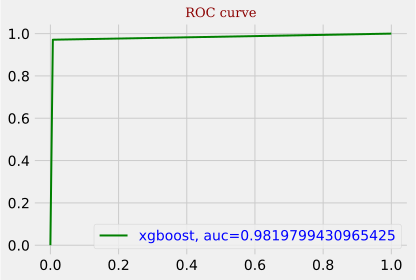

In [86]:
plot(test_label, y_pred, "xgboost")

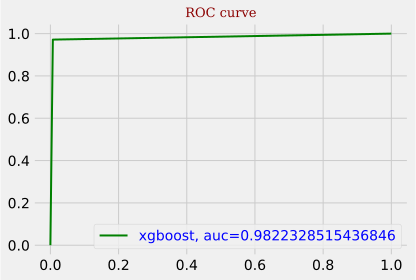

In [92]:
plot(test_label, y_pred, "xgboost")

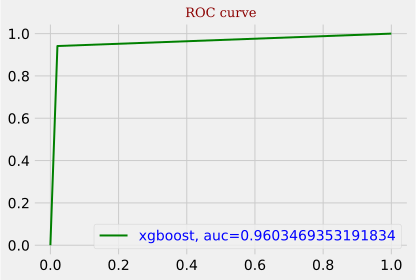

In [114]:
plot(test_label, y_pred, "xgboost")

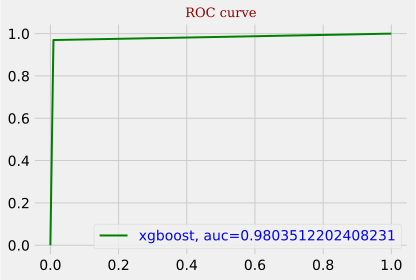

In [117]:
plot(test_label, y_pred, "xgboost")

In [106]:
def calc_score(y_pred, test_label):
    return (((y_pred == test_label).sum(axis=0)
            - (y_pred - test_label) @ y_pred) 
            / y_pred.shape[0])

In [111]:
calc_score(y_pred, test_label.values.flatten())

0.9781666666666666

In [119]:
calc_score(y_pred, test_label.values.flatten())

0.978

In [132]:
with open("bc_model_oof_test.csv", "rb") as fp:
    bc = pickle.load(fp)

In [125]:
d.sum()

4914.4

In [127]:
lr.sum()

4834.1

In [129]:
gbc.sum()

4860.5

In [131]:
bnb.sum()

2808.5

In [133]:
bc.sum()

4912.5

In [3]:
with open("lr_model_oof_train.csv", "rb") as fp:
    lr_model_oof_train = pickle.load(fp)
with open("lr_model_oof_test.csv", "rb") as fp:
    lr_model_oof_test = pickle.load(fp)
    
with open("gbc_model_oof_train.csv", "rb") as fp:
    gbc_model_oof_train = pickle.load(fp)
with open("lr_model_oof_test.csv", "rb") as fp:
    gbc_model_oof_test = pickle.load(fp)
    
with open("bc_model_oof_train.csv", "rb") as fp:
    bc_model_oof_train = pickle.load(fp)
with open("lr_model_oof_test.csv", "rb") as fp:
    bc_model_oof_test = pickle.load(fp)
    
with open("svm_model_oof_train.csv", "rb") as fp:
    svm_model_oof_train = pickle.load(fp)
with open("svm_model_oof_test.csv", "rb") as fp:
    svm_model_oof_test = pickle.load(fp)
    
with open("dt_model_oof_train.csv", "rb") as fp:
    dt_model_oof_train = pickle.load(fp)
with open("dt_model_oof_test.csv", "rb") as fp:
    dt_model_oof_test = pickle.load(fp)
    
with open("ret_value_lr_model_oof_train.csv", "rb") as fp:
    ret_value_lr_model_oof_train = pickle.load(fp)
with open("ret_value_lr_model_oof_test.csv", "rb") as fp:
    ret_value_lr_model_oof_test = pickle.load(fp)
    
with open("ret_value_gbc_model_oof_train.csv", "rb") as fp:
    ret_value_gbc_model_oof_train = pickle.load(fp)
with open("ret_value_lr_model_oof_test.csv", "rb") as fp:
    ret_value_gbc_model_oof_test = pickle.load(fp)
    
with open("ret_value_bc_model_oof_train.csv", "rb") as fp:
    ret_value_bc_model_oof_train = pickle.load(fp)
with open("ret_value_bc_model_oof_test.csv", "rb") as fp:
    ret_value_bc_model_oof_test = pickle.load(fp)
    
with open("ret_value_svm_model_oof_train.csv", "rb") as fp:
    ret_value_svm_model_oof_train = pickle.load(fp)
with open("ret_value_svm_model_oof_test.csv", "rb") as fp:
    ret_value_svm_model_oof_test = pickle.load(fp)
    
with open("ret_value_dt_model_oof_train.csv", "rb") as fp:
    ret_value_dt_model_oof_train = pickle.load(fp)
with open("ret_value_dt_model_oof_test.csv", "rb") as fp:
    ret_value_dt_model_oof_test = pickle.load(fp)

In [5]:
api_name_train = np.hstack([lr_model_oof_train, gbc_model_oof_train, bc_model_oof_train,
                            svm_model_oof_train, dt_model_oof_train])
api_name_test = np.hstack([lr_model_oof_test, gbc_model_oof_test, bc_model_oof_test,
                           svm_model_oof_test, dt_model_oof_test])
ret_value_train = np.hstack([ret_value_lr_model_oof_train, ret_value_gbc_model_oof_train, ret_value_bc_model_oof_train,
                             ret_value_svm_model_oof_train, ret_value_dt_model_oof_train])
ret_value_test = np.hstack([ret_value_lr_model_oof_test, ret_value_gbc_model_oof_test, ret_value_bc_model_oof_test,
                             ret_value_svm_model_oof_test, ret_value_dt_model_oof_test])

In [7]:
train = np.hstack([api_name_train, ret_value_train])
test = np.hstack([api_name_test, ret_value_test])
safe_type = pd.read_csv("safe_type.csv", header=None)

In [15]:
train_data, test_data, train_label, test_label = train_test_split(ret_value_train, 
                                                                  safe_type, 
                                                                  test_size=0.2, 
                                                                  random_state=1)

In [16]:
model = XGBClassifier(n_estimators=3000, learning_rate=0.05, max_depth=7) 
model.fit(train_data, train_label.values.flatten())
y_pred = model.predict(test_data)

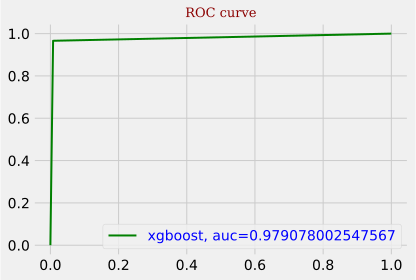

In [11]:
plot(test_label, y_pred, "xgboost")

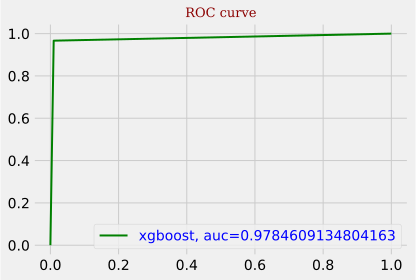

In [14]:
plot(test_label, y_pred, "xgboost")

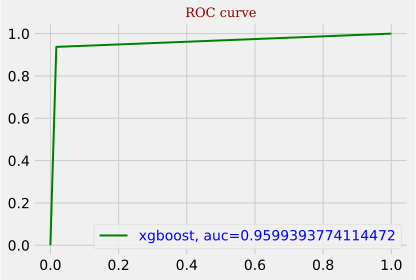

In [17]:
plot(test_label, y_pred, "xgboost")

In [18]:
import time
import numpy as np
import pandas as pd
import pickle
import dask.array as da
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.externals import joblib

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

with open("train_ret_value_tfidf_features.pkl", "rb") as fp:
    train_tfidf_features = pickle.load(fp)
with open("test_ret_value_tfidf_features.pkl", "rb") as fp:
    test_tfidf_features = pickle.load(fp)
safe_type = pd.read_csv("safe_type.csv", header=None)
bc_model = BaggingClassifier()
gbc_model = GradientBoostingClassifier()
lr_model = LogisticRegression()
svm_model = svm.LinearSVC()
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(max_depth=7,
                          learning_rate=0.05,
                          n_estimators=1000)

rfc_model = RandomForestClassifier(200)
etc_model = ExtraTreesClassifier()
mnb_model = naive_bayes.MultinomialNB(alpha=0.01)
ada_model = AdaBoostClassifier()

def get_oof(model, x_train, y_train, x_test, n_splits):
    """
    :@param x_train: feature matrix.
    :type x: np.array(M X N) or list(M X N).
    :@param y_train: class label.
    :type y: int.
    :@param x_test: test set feature matrix.
    :type x_test: np.array(M X N) or list(M X N).
    :@param n_splits: K-fold parameter.
    :type n_splits: int.
    """
    n_train, n_test = x_train.shape[0], x_test.shape[0]
    kf = StratifiedKFold(n_splits=n_splits, random_state=0)
    oof_train = np.empty((n_train, ))
    oof_test = np.empty((n_test, ))
    oof_test_skf = np.empty((n_splits, n_test))
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        kf_x_train = x_train[train_index]
        kf_y_train = y_train[train_index]
        kf_x_test = x_train[test_index]
        model.fit(kf_x_train, kf_y_train)
        oof_train[test_index] = model.predict(kf_x_test)
        oof_test_skf[i, :] = model.predict(x_test)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

try:
    xgb_model_oof_train, xgb_model_oof_test = get_oof(xgb_model, 
                                                      train_tfidf_features.tolil(), 
                                                      safe_type.values,
                                                      test_tfidf_features.tolil(),
                                                      10)
    with open("ret_value_xgb_model_oof_train.csv", "wb") as fp:
        pickle.dump(xgb_model_oof_train, fp)
    with open("ret_value_xgb_model_oof_test.csv", "wb") as fp:
        pickle.dump(xgb_model_oof_test, fp)
    print("xgb success!")
except:
    print("xgb error!")

xgb success!
